<a href="https://colab.research.google.com/github/dborgesm/Banking-Analytics/blob/master/Data_Preprocessing_for_LGD_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [0]:
#Installing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!gdown https://drive.google.com/uc?id=1WPvaqsGs7dE6B9Ahrs_56nG8ZwGbi4FF

Downloading...
From: https://drive.google.com/uc?id=1WPvaqsGs7dE6B9Ahrs_56nG8ZwGbi4FF
To: /content/LCFinal.csv
1.64GB [00:18, 91.2MB/s]


In [0]:
# Loading data
lending_data = pd.read_csv('/content/LCFinal.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,17,47,56,115,126,127,128,131,132,133,136,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Missing Values**

<function matplotlib.pyplot.show>

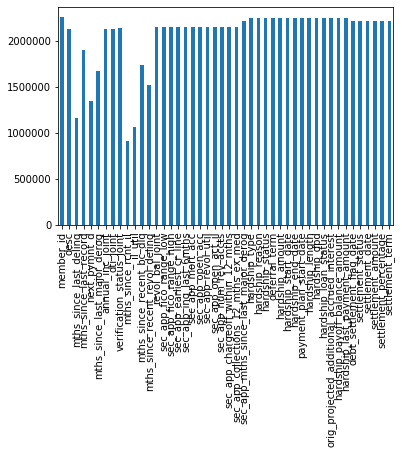

In [0]:
na_col = lending_data.isnull().sum()
na_col = na_col[na_col >0.4*len(lending_data)]
na_col
na_col.plot(kind='bar')
plt.show

Dropping the columns with more than 80% of missing values and the unnecesary columns Unnamed: 0, id and url.

In [0]:
length = len(lending_data)
lending_data2 = lending_data.copy()
lending_data2.drop(lending_data.loc[:,lending_data.isnull().sum()/length >.8], inplace=True, axis=1)

Dropping the rows with many missing values (more than 100 missing values)

In [0]:
na_rows = lending_data2[lending_data2.isnull().sum(axis=1)>100].index
lending_data2.drop(na_rows, inplace=True)

The information required in the application scoring is the one at the moment of the loan is acquired, so next payment date, issue date, last credit pull d and last payment d are not necessary in the model because they are future information. 

In [0]:
lending_data2 = lending_data2.drop(['Unnamed: 0', 'id', 'url', 'issue_d', 'next_pymnt_d', 'last_credit_pull_d', 'last_pymnt_d'], axis=1)

Dropping rows where loan_status is equal to "Does not meet the credit policy", the company will never give these people a loan.

In [0]:
no_meeting_policy = lending_data2[lending_data2.loan_status.str.contains('Status:')].index
lending_data2.drop(no_meeting_policy, inplace=True)

Modifying some values of the database

In [0]:
#Extracting the first 3 values of the zip code. 
lending_data2['zip_code'] = lending_data2['zip_code'].str.extract(r'([\d\.]+)')

Employment title had more than 200 categories and contained invalid values, and even if new categories were made, they couldn’t reach statistical significance 

In [0]:
lending_data2.drop(['emp_title'], inplace=True, axis=1)

In [0]:
# extracting the numeric values of term
lending_data2['term'] = lending_data2['term'].str.extract(r'([\d\.]+)')

## **Creating objective variable for LGD Model**

In [0]:
lgd_data = lending_data2[lending_data2.loan_status == "Charged Off"]
lgd_data = lgd_data.reset_index(drop=True)

In [0]:
def lgd_cal(loan, t_pymnt,principal, inte, fee):
  if loan == principal:
    return 0
  else:
    lgd = 1-(t_pymnt-principal-inte-fee)/(loan-principal)
    if lgd < 0:
      return 0
    else:
      return lgd



In [0]:
lgd_data["lgd"] = lgd_data.apply(lambda x: lgd_cal(x['loan_amnt'], x['total_pymnt'], x['total_rec_prncp'], x['total_rec_int'], x['collection_recovery_fee']), axis=1)

In [0]:
# LGD Percentiles
lgd_data["lgd"].describe()

count    268559.000000
mean          0.907632
std           0.111681
min           0.000000
25%           0.879701
50%           0.915176
75%           1.000000
max           1.000005
Name: lgd, dtype: float64

Let's eliminate the variable used to predict the objective variable they won't be necessary anymore in the model.

In [0]:
lgd_data.drop(["out_prncp", "out_prncp_inv"], axis=1, inplace=True)

In [0]:
lending_data2.drop(["out_prncp", "out_prncp_inv"], axis=1, inplace=True)

## **Correlation**

In [0]:
corr_lgd = lgd_data.corr()

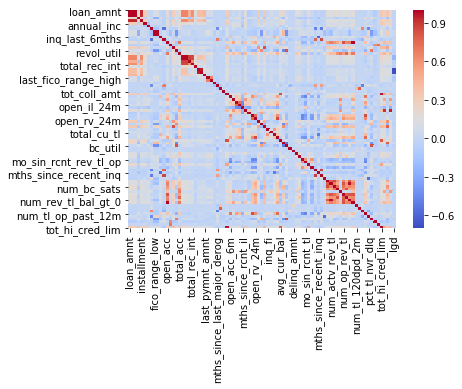

In [0]:
sns.heatmap(corr_lgd, cmap= 'coolwarm',linecolor='black')

I will be dropping some variables that are not related to the pd model, because they contain future information. 

In [0]:
drop_col = ["loan_amnt","installment", "total_rec_prncp", "total_rec_int",
          "total_rec_late_fee", "recoveries", "last_pymnt_amnt",
          "total_pymnt", "total_pymnt_inv", "collection_recovery_fee",
          "title", "funded_amnt", "funded_amnt_inv", "earliest_cr_line",
          "application_type","int_rate"
]

In [0]:
lgd_data.drop(drop_col,axis=1, inplace=True)
lending_data2.drop(drop_col, axis=1, inplace=True)

Dropping the correlated variables

In [0]:
corr_val = ["fico_range_low","last_fico_range_low", "last_fico_range_high", 
            "open_acc", "total_rev_hi_lim", "avg_cur_bal", "revol_util", "mths_since_recent_bc_dlq",
            "mths_since_recent_revol_delinq","num_op_rev_tl", "num_rev_accts", "num_sats", "acc_now_delinq",
            "num_tl_op_past_12m", "tax_liens", "tot_hi_cred_lim", "open_il_24m", "open_rv_24m", "acc_open_past_24mths",
            "bc_util", "total_bal_il", "total_bc_limit", "total_il_high_credit_limit", "total_bal_ex_mort",
            "num_actv_rev_tl", "num_actv_bc_tl", "num_rev_tl_bal_gt_0", "num_bc_sats", "num_bc_tl"
            ]

In [0]:
lgd_data.drop(corr_val, inplace=True, axis=1)
lending_data2.drop(corr_val, axis=1, inplace=True)
# Dropping loan status we already know they are charged off
lgd_data.drop(["loan_status"], axis=1, inplace=True)

### **Categorical Variables**

The categorical variables that contained only one unique value were eliminated, because they would not add any information to the model as they were. Even though, hardship flag is an essential variable for the LGD model this was removed.


In [0]:
loans = lgd_data.loc[:,lgd_data.apply(pd.Series.nunique) != 1]

In [0]:
# Looking at the variables with less than 4 unique variables and see if they can achieve statistical significance
drop_c = []
for col in loans.columns:
    if (len(loans[col].unique()) < 4):
      print(loans[col].value_counts())
      print()
      drop_c.append(col)

36    163252
60    105307
Name: term, dtype: int64

w    158440
f    110119
Name: initial_list_status, dtype: int64

Cash         267174
DirectPay      1385
Name: disbursement_method, dtype: int64

N    235288
Y     33271
Name: debt_settlement_flag, dtype: int64



Disbursement method and hardship flag will be eliminated because it has less than 5% of the cases

In [0]:
lgd_data.drop(["disbursement_method"], axis=1, inplace=True)
lgd_data.drop(["mths_since_last_major_derog"], axis=1,inplace=True)
lgd_data.drop(["hardship_flag"], axis=1,inplace=True)

## **Handling Missing Values**

In [0]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 4000)
null_counts = lgd_data.isnull().mean()
print("Number of null values in each column:\n{}".format(100*(null_counts)))

The numeric variables with less than 4% of missing values will be filled with the median of that variable

In [0]:
num_var = lgd_data.drop(['lgd'], axis=1).select_dtypes(include = [np.number])
null_nv = num_var.isnull().mean()*100

In [0]:
for i in num_var:
  if (null_nv[i] < 6) & (null_nv[i]> 0.000045):
    lgd_data[i].fillna(lgd_data[i].median(), inplace=True)  

The other numeric variables with significant missing values after analyzing them they will be filled with 0 because it made references to products that the client dont have.

In [0]:
for i in num_var:
  if (null_nv[i] > 6):
    lgd_data[i].fillna(0, inplace=True)

I will replace employment date with the mode eventhough there are 6% of null cases value but it will be worst if we dropped this values

In [0]:
emp = lgd_data.emp_length.mode().values[0]
lgd_data.emp_length.fillna(emp, inplace=True)

## Outliers
Subsequently, for each remaining variable, a boxplot and a histogram were used to spot the outliers. For example, for income, the users with income greater than $300,000 were removed because our sample will not represent them

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


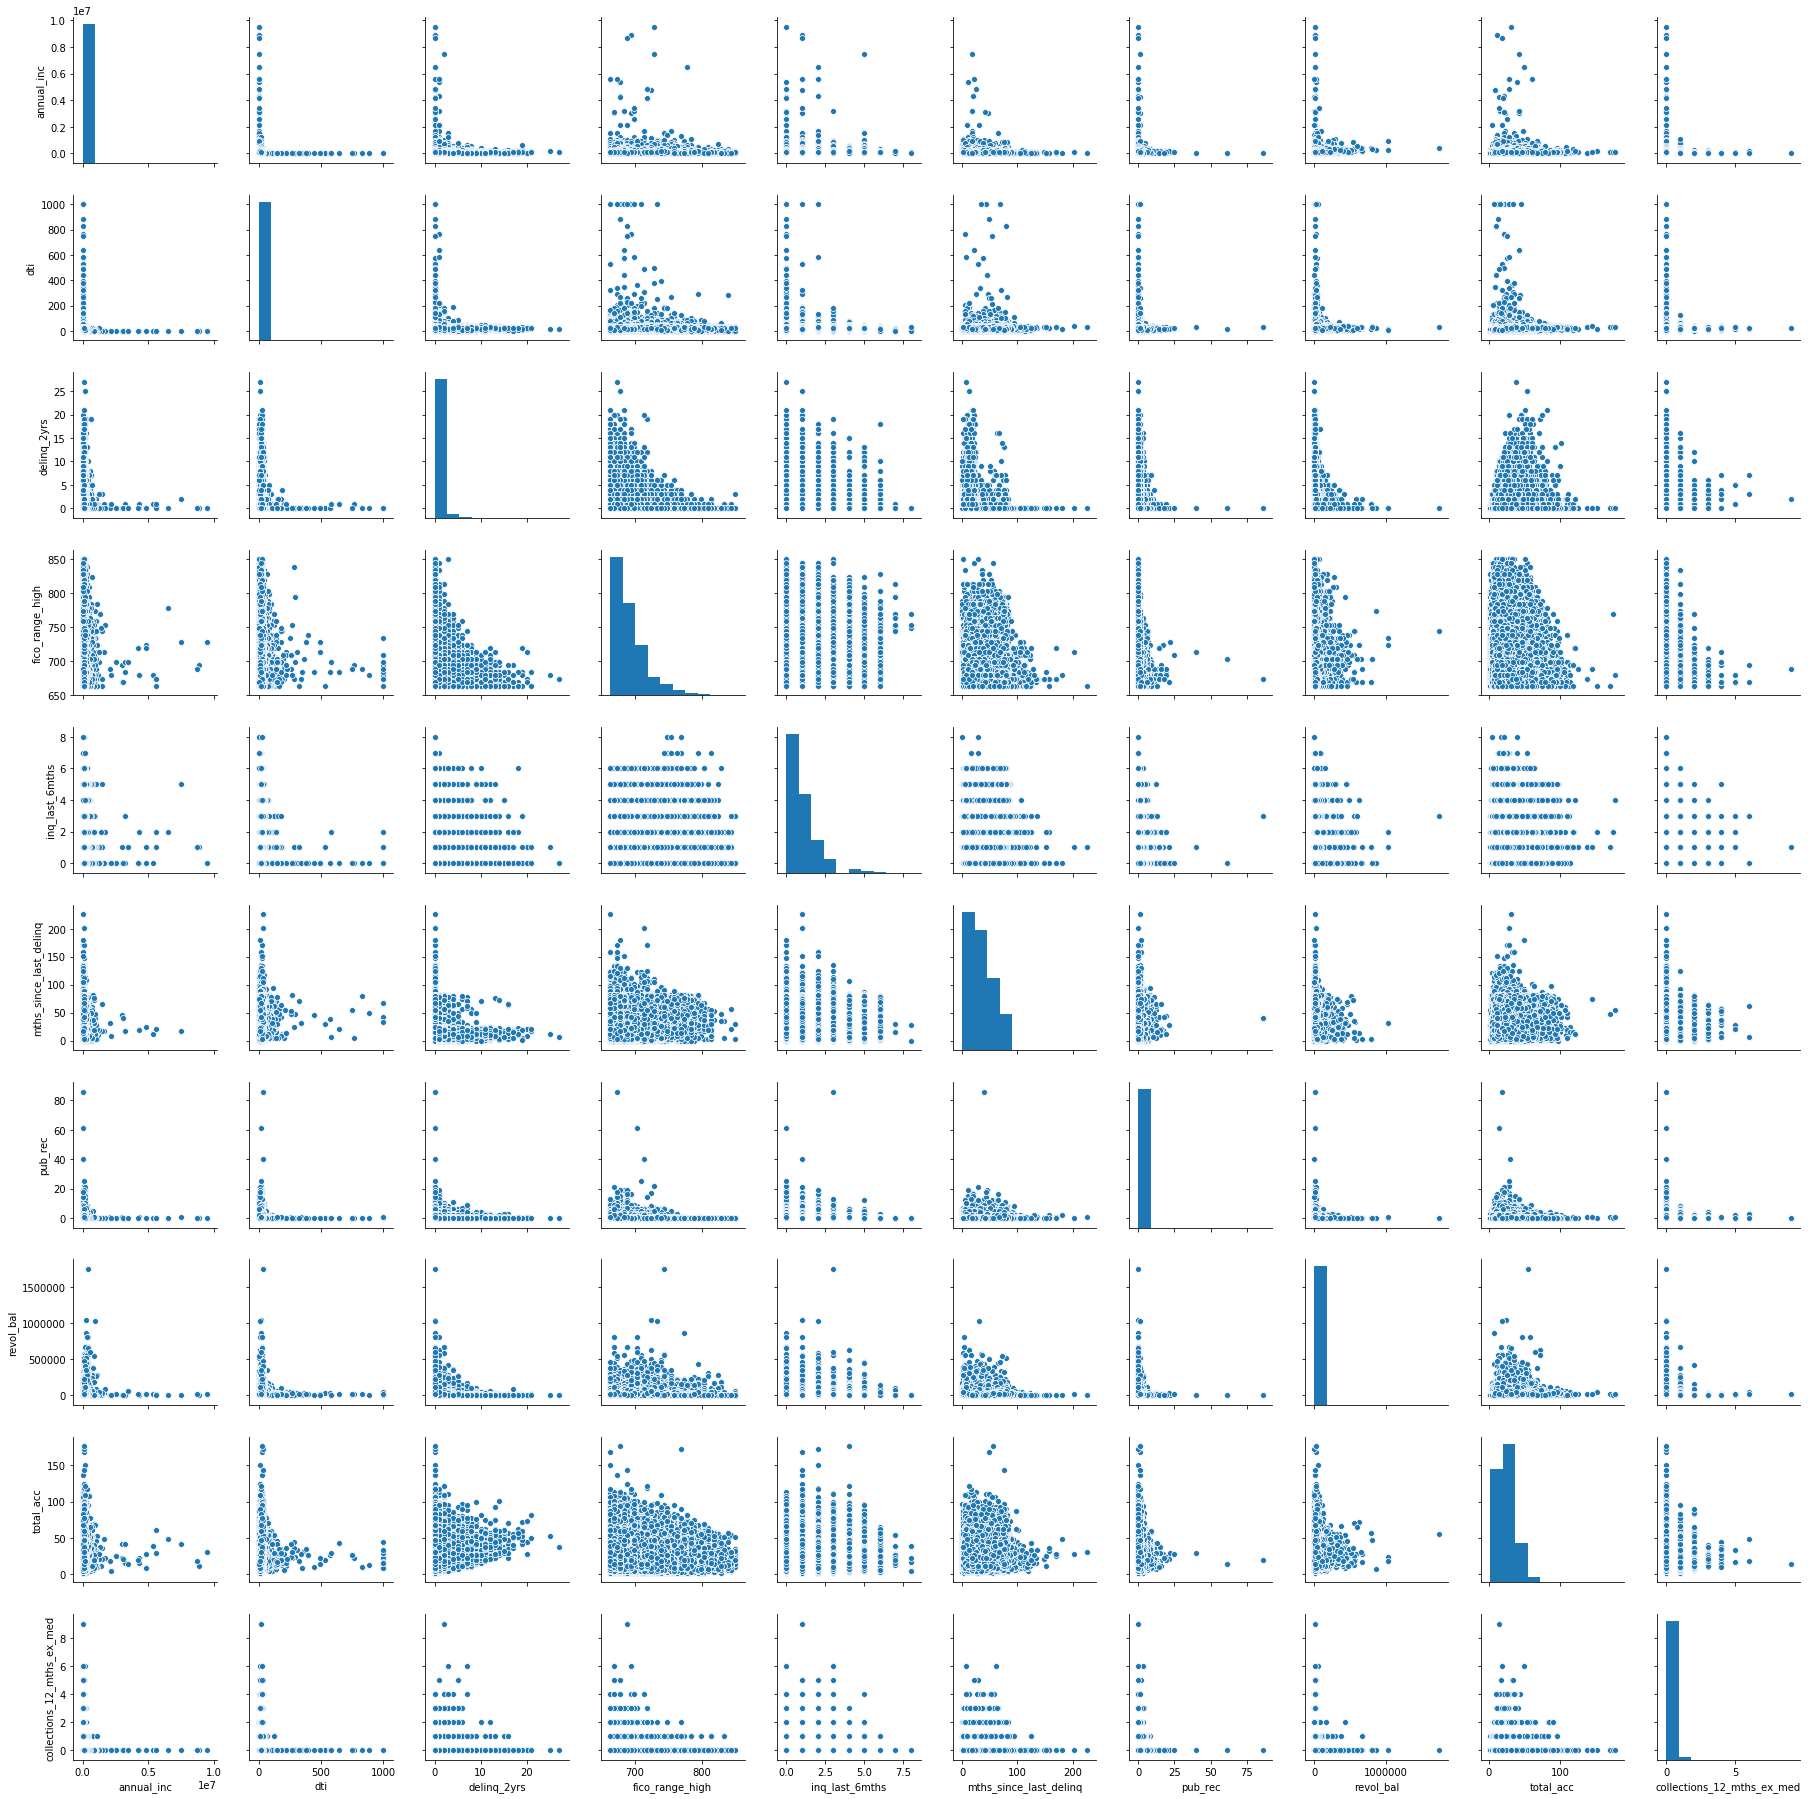

In [0]:
sns.pairplot(num_var.iloc[:,:10])

## annual income

In [0]:
fig, ax = plt.subplots(1,2, figsize=(18, 8))
sns.boxplot(lgd_data.annual_inc, orient="v", ax=ax[0])
sns.distplot(lgd_data.annual_inc, ax=ax[1])

People with income higher than 300,000 because they are not representative in the sample

In [0]:
lgd_data = lgd_data.loc[(lgd_data.annual_inc < 300000)]

## DTI 

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.dti, orient="v", ax=ax[0])
sns.distplot(lgd_data.dti,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.dti < 80)]

Dti should be cut off to less than 80

## Delinq 2years

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.delinq_2yrs, orient="v", ax=ax[0])
sns.distplot(lgd_data.delinq_2yrs,ax=ax[1])

We will remove the outliers delinq 2 years > 30 and make a binary variable 0 and 1 which will mean more than 1 delinq in 2 year

In [0]:
lgd_data = lgd_data.loc[(lgd_data.delinq_2yrs < 20)]

In [0]:
d2y = np.array(lgd_data[lgd_data.delinq_2yrs>0].delinq_2yrs.index)
lgd_data.loc[d2y.transpose(), "delinq_2yrs"] = 1

## FICO range high

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.fico_range_high, orient="v", ax=ax[0])
sns.distplot(lgd_data.fico_range_high,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.fico_range_high < 825)]

Outliers greater than 825 will be removed

## Inquiries last 6 months

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.inq_last_6mths, orient="v", ax=ax[0])
sns.distplot(lgd_data.inq_last_6mths,ax=ax[1])

I will re group them from 0, 1 and greater than 2 (2 to 8)

In [0]:
il6m = np.array(lgd_data[lgd_data.inq_last_6mths>=2].inq_last_6mths.index)
lgd_data.loc[il6m.transpose(), "inq_last_6mths"] = 2

## Months since last delinq

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.mths_since_last_delinq, orient="v", ax=ax[0])
sns.distplot(lgd_data.mths_since_last_delinq,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mths_since_last_delinq < 95)]

The outliers greater than 95 will be removed

## Pub Rec

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.pub_rec, orient="v", ax=ax[0])
sns.distplot(lgd_data.pub_rec,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.pub_rec < 6)]

In [0]:
pubrec = np.array(lgd_data[lgd_data.pub_rec>=1].inq_last_6mths.index)
lgd_data.loc[pubrec.transpose(), "pub_rec"] = 1

The variable have many outliers we will keep only the ones less than 5 and convert this as a binary variable 0 and 1 one will be the pub records greater than one 0 (1 to 5)

## Revol Bal

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.revol_bal, orient="v", ax=ax[0])
sns.distplot(lgd_data.revol_bal,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.revol_bal < 140000)]

Outliers greater than 140 will be removed

Total Acc

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.total_acc, orient="v", ax=ax[0])
sns.distplot(lgd_data.total_acc,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.total_acc < 100)]

Outliers greater or equal than 100 will be removed

## Collections 12 months ex med

I will be removing this column because even if we convert it to binary the second case wont have 5% of this cases meaning that this wont be a significant variable  for modelling

In [0]:
lgd_data.drop(["collections_12_mths_ex_med"], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


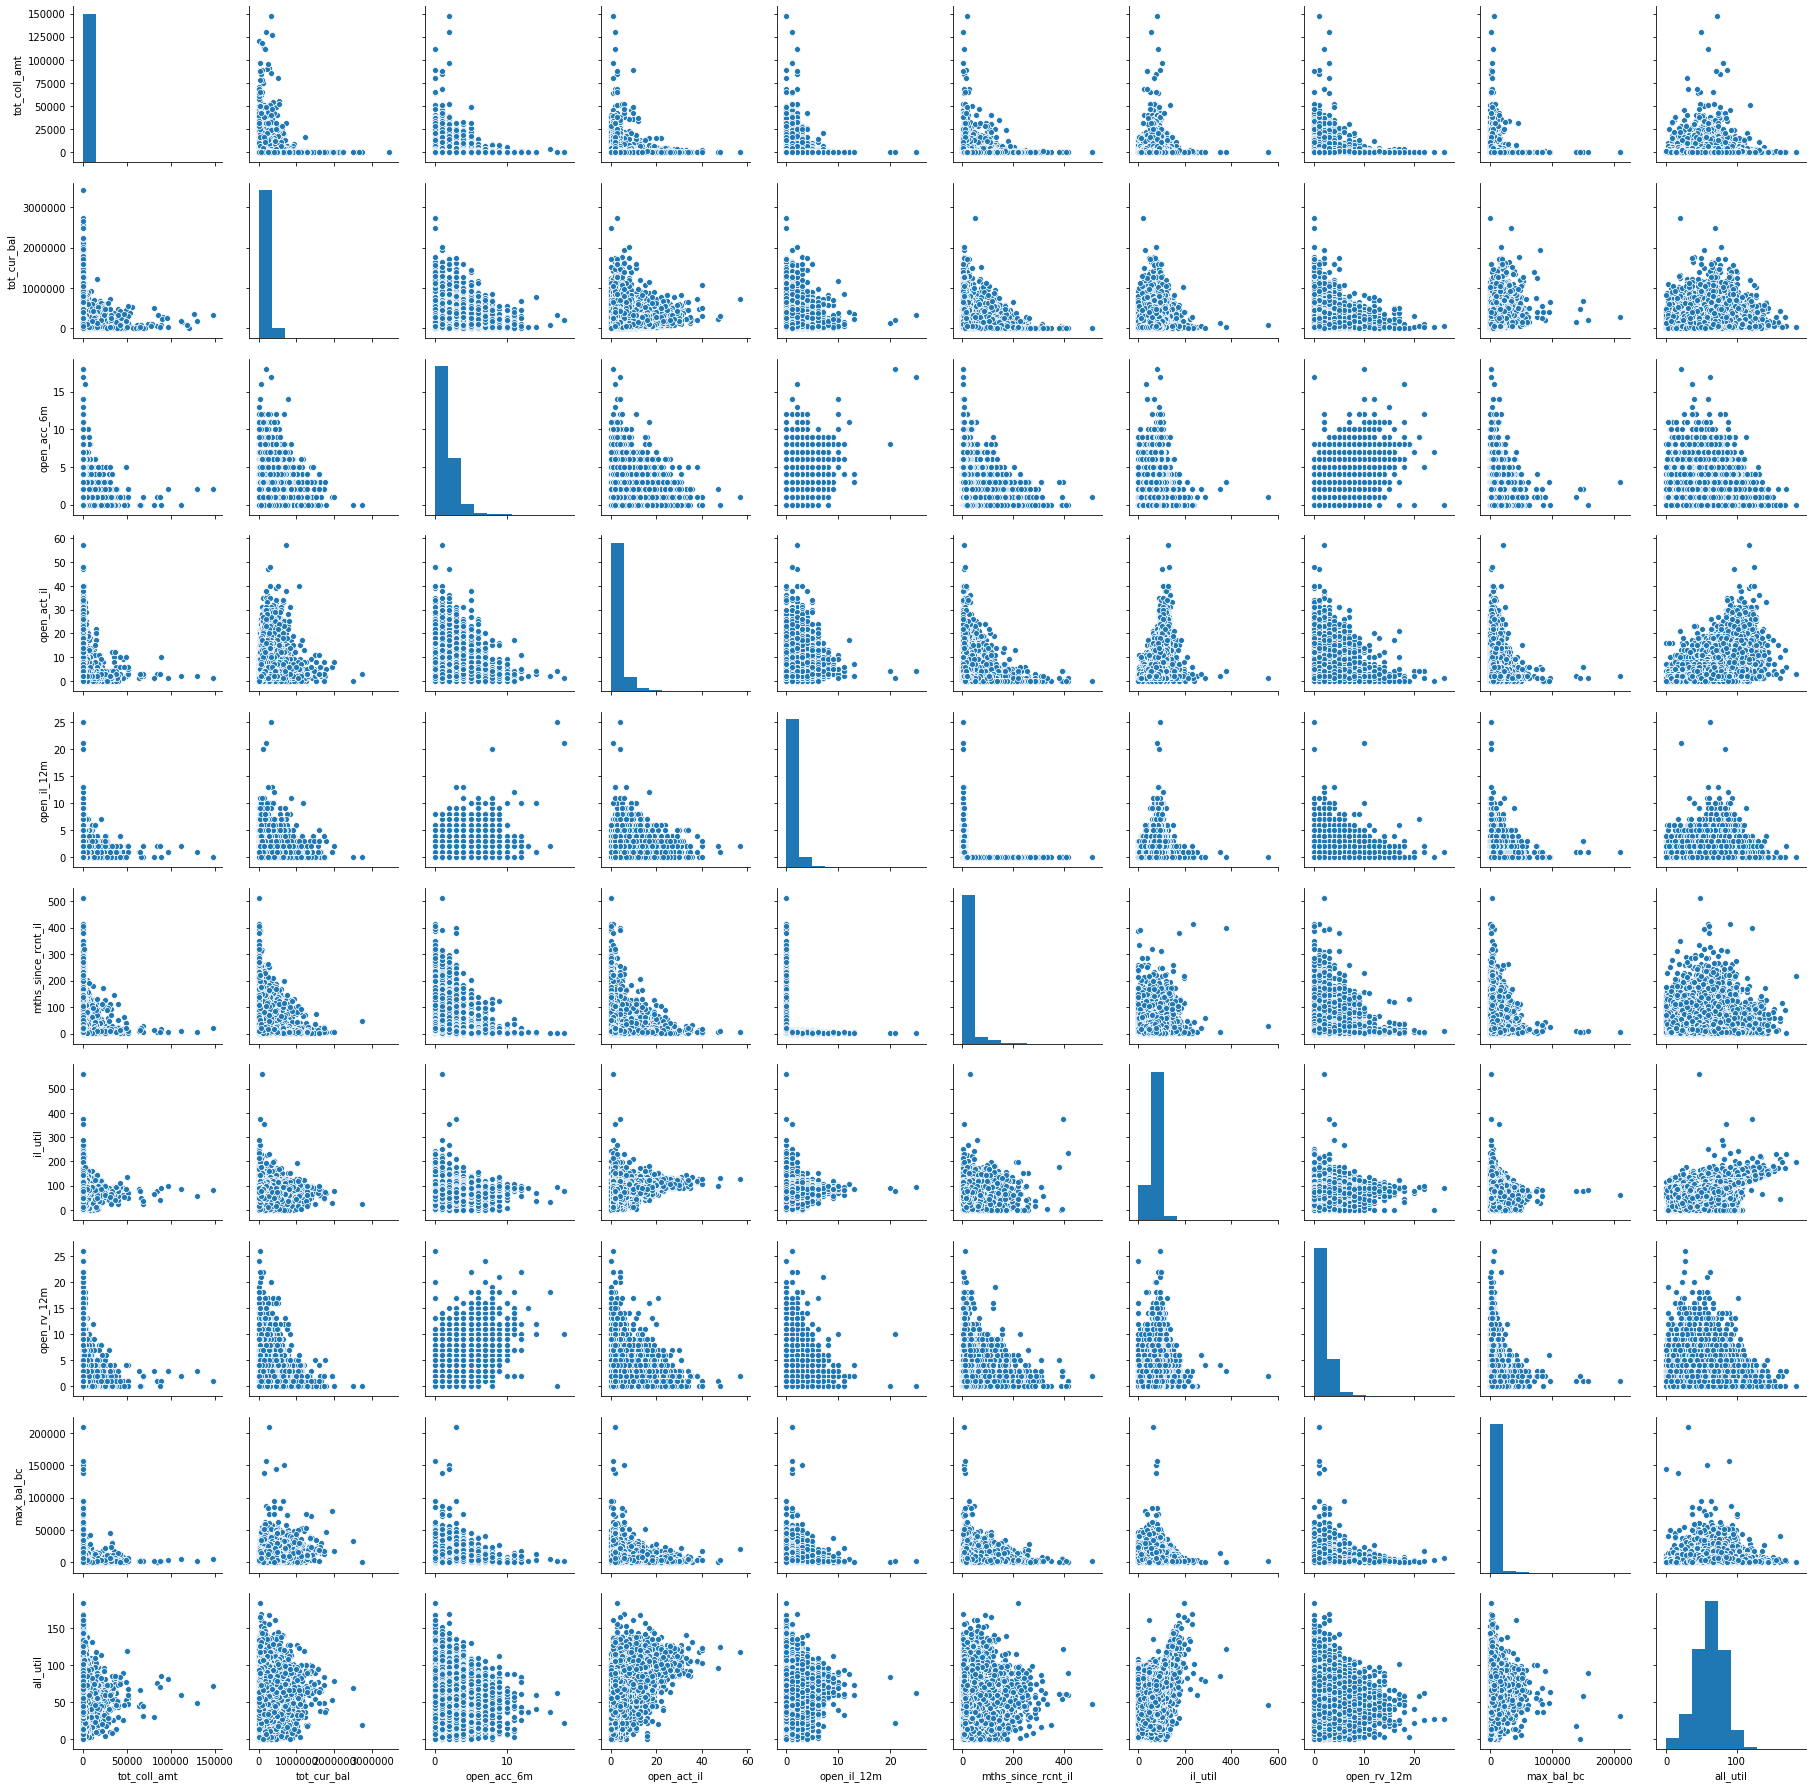

In [0]:
sns.pairplot(num_var.iloc[:,10:20])

##Total Collection amount

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.tot_coll_amt, orient="v", ax=ax[0])
sns.distplot(lgd_data.tot_coll_amt,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.tot_coll_amt < 10000)]

I will remove the outliers greater than 10000

## Tot Cur Bal

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.tot_cur_bal, orient="v", ax=ax[0])
sns.distplot(lgd_data.tot_cur_bal,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.tot_cur_bal < 1000000)]

Outliers greater than 1000000 will be removed

## Open Acc 6 mths

In [0]:
fig, ax = plt.subplots(1,2)
sns.boxplot(lgd_data.open_acc_6m, orient="v", ax=ax[0])
sns.distplot(lgd_data.open_acc_6m,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.open_acc_6m <=5)]

In [0]:
open_acc6 = np.array(lgd_data[lgd_data.open_acc_6m>=2].open_acc_6m.index)
lgd_data.loc[open_acc6.transpose(), "open_acc_6m"] = 2

Outliers greater than 5 will be removed and they will be regroup to 0 1 and greater than 2

## Open Account Il

In [0]:
fig, ax = plt.subplots(1,2,figsize=(18, 8) )
sns.boxplot(lgd_data.open_act_il, orient="v", ax=ax[0])
sns.distplot(lgd_data.open_act_il,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.open_act_il < 20)]

In [0]:
oai45 = np.array(lgd_data[(lgd_data.open_act_il>=4) & (lgd_data.open_act_il<=5)].open_act_il.index)
lgd_data.loc[oai45.transpose(), "open_act_il"] = 4
oai = np.array(lgd_data[lgd_data.open_act_il>=6].open_act_il.index)
lgd_data.loc[oai.transpose(), "open_act_il"] = 6

we will remove the outliers greater than 20 and will regroup  4 to 5 and  6 to 20.

## mths since recent il

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mths_since_rcnt_il, orient="v", ax=ax[0])
sns.distplot(lgd_data.mths_since_rcnt_il,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mths_since_rcnt_il <=150)]

Outliers greater than 150 will be removed

##Il util

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.il_util, orient="v", ax=ax[0])
sns.distplot(lgd_data.il_util,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.il_util <=200)]

Outliers greater than 200 will be removed

## Open Revol 12 mnths

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.open_rv_12m, orient="v", ax=ax[0])
sns.distplot(lgd_data.open_rv_12m,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.open_rv_12m <=7)]

Outliers greater than 7 will be removed

## Max bal bc

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.max_bal_bc, orient="v", ax=ax[0])
sns.distplot(lgd_data.max_bal_bc,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.max_bal_bc <=50000)]

Outliers greater than 50000 will be removed because my model will not be representing them 

## All util

This one is fine



In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.all_util, orient="v", ax=ax[0])
sns.distplot(lgd_data.all_util,ax=ax[1])

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


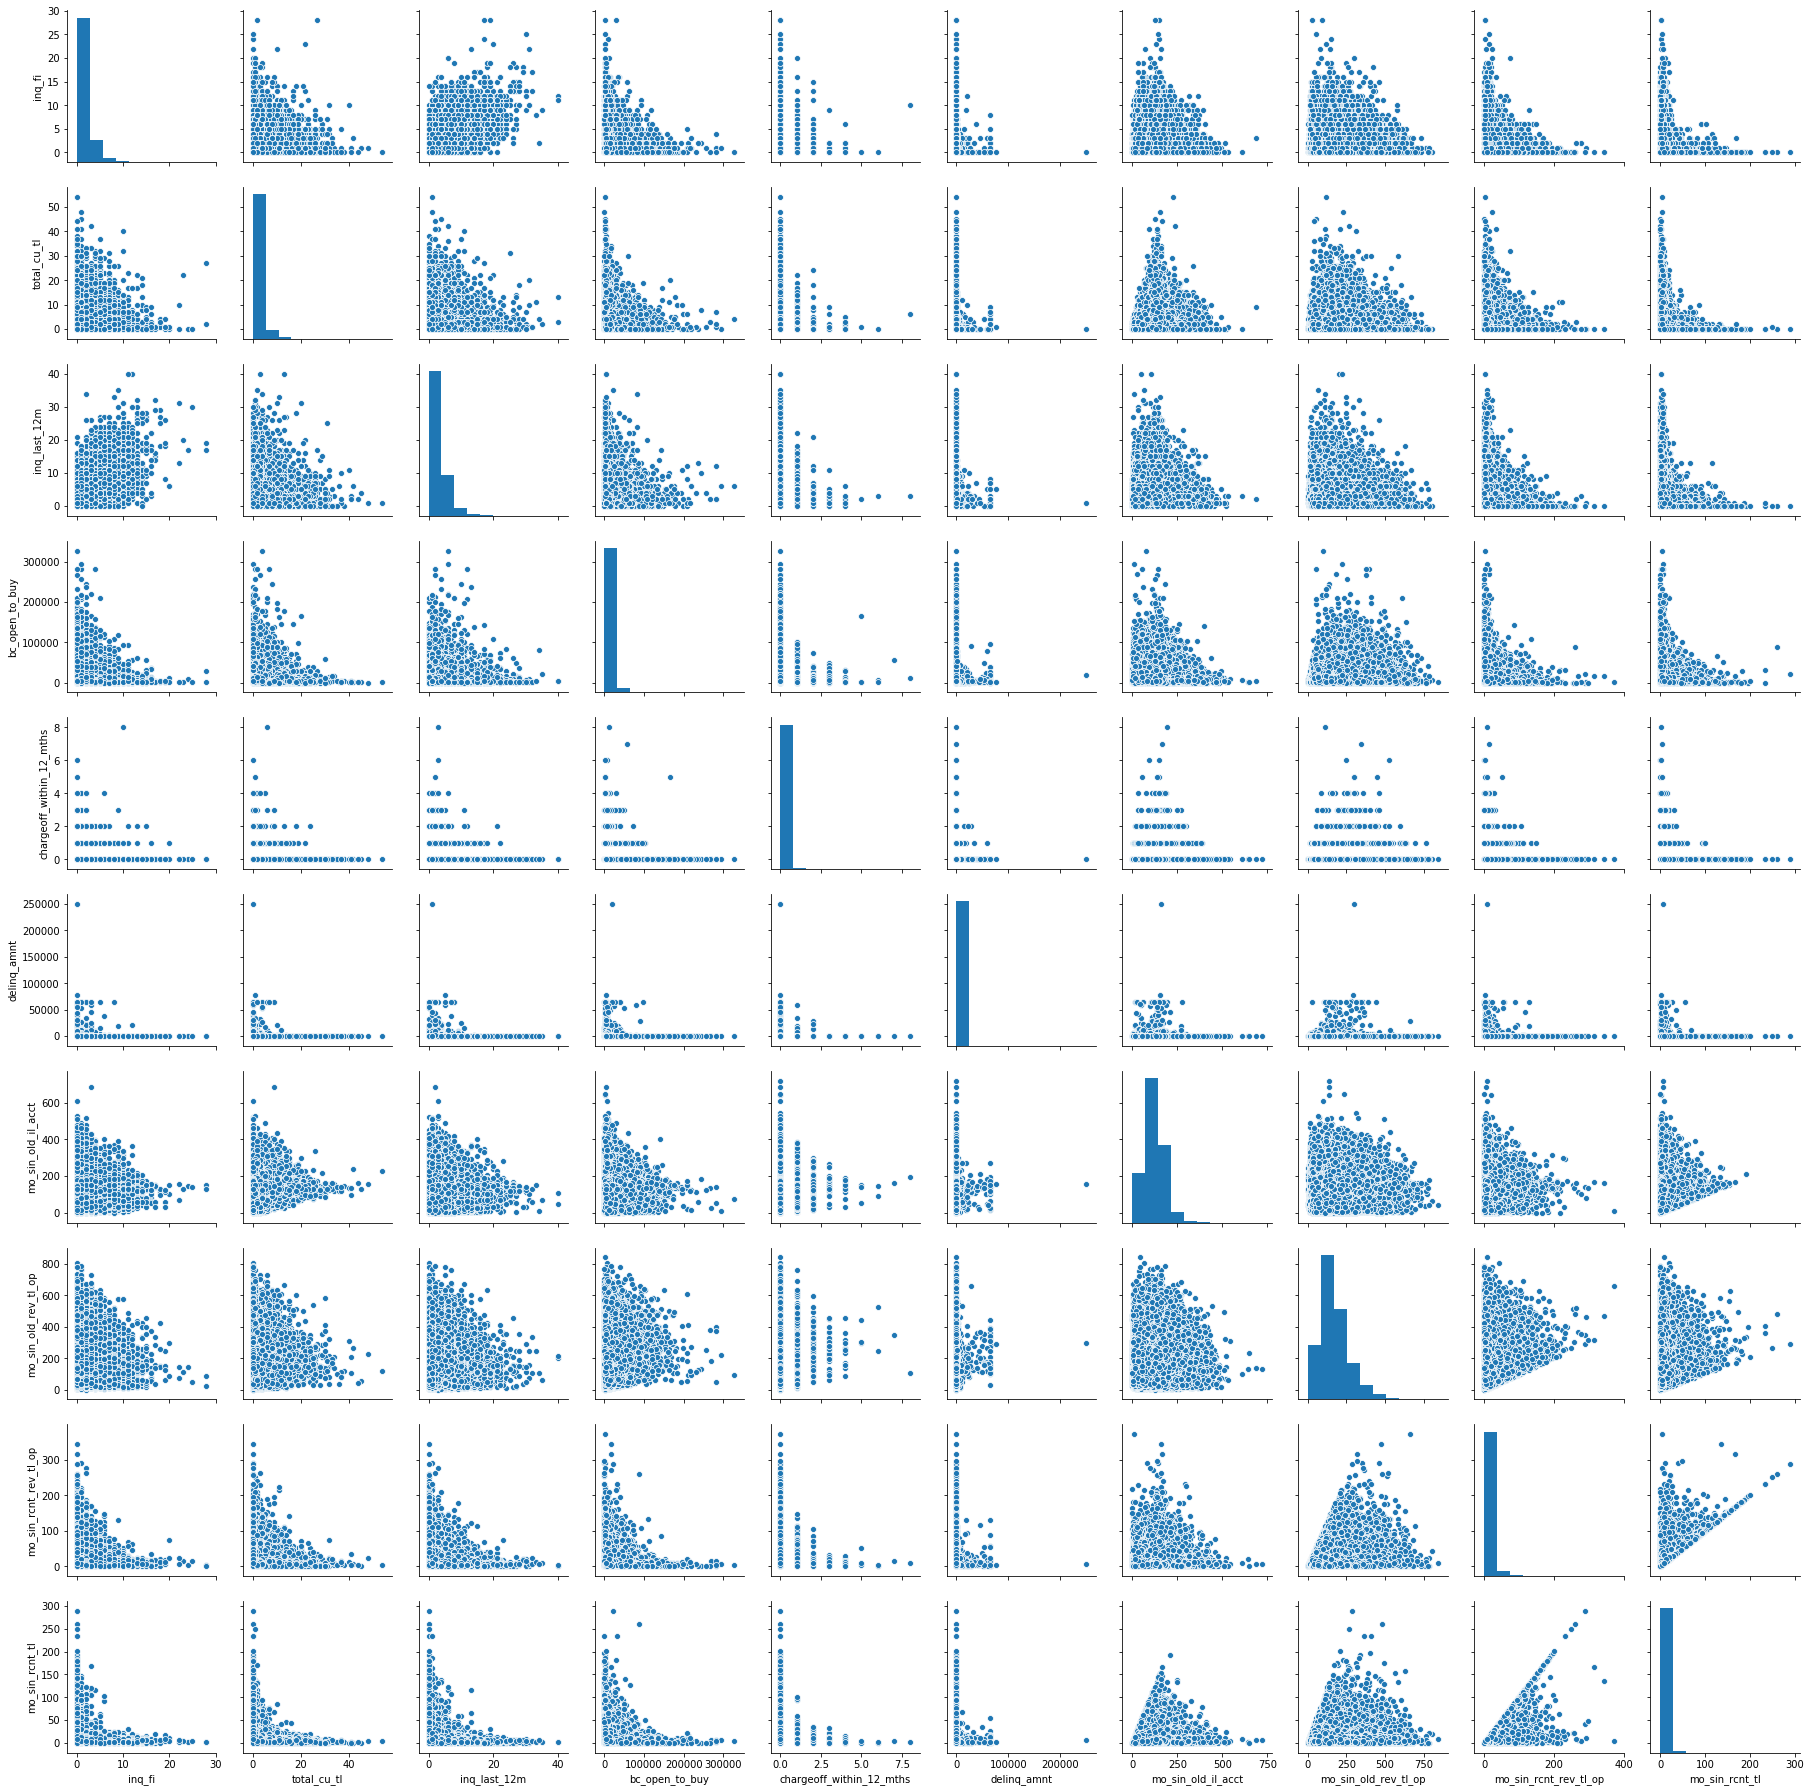

In [0]:
sns.pairplot(num_var.iloc[:,20:30])

## Inq fi

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.inq_fi, orient="v", ax=ax[0])
sns.distplot(lgd_data.inq_fi,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.inq_fi <=10)]

In [0]:
inqfi = np.array(lgd_data[lgd_data.inq_fi>=3].inq_fi.index)
lgd_data.loc[inqfi.transpose(), "inq_fi"] = 3

Remove outliers greater than 10 and regrouped them 0,1,2 angreater or equal to 3

##Total Cu Tl

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.total_cu_tl, orient="v", ax=ax[0])
sns.distplot(lgd_data.total_cu_tl,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.total_cu_tl <=20)]

In [0]:
tct23 = np.array(lgd_data[(lgd_data.total_cu_tl>=2) & (lgd_data.total_cu_tl<=3)].total_cu_tl.index)
lgd_data.loc[tct23.transpose(), "total_cu_tl"] = 2

tct4 = np.array(lgd_data[(lgd_data.total_cu_tl>=4)].total_cu_tl.index)
lgd_data.loc[tct4.transpose(), "total_cu_tl"] = 3

## Inq last 12m

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.inq_last_12m, orient="v", ax=ax[0])
sns.distplot(lgd_data.inq_last_12m,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.inq_last_12m <=15)]

Outliers greater than 15 will be removed

#Bc open to buy

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.bc_open_to_buy, orient="v", ax=ax[0])
sns.distplot(lgd_data.bc_open_to_buy,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.bc_open_to_buy <=175000)]

Outliers greater than 175000 will be removed

## Charged off within 12 mths

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.chargeoff_within_12_mths, orient="v", ax=ax[0])
sns.distplot(lgd_data.chargeoff_within_12_mths,ax=ax[1], kde=False)

This variable will be eliminated because even though we converted in binary the second case wont have 5% of the cases, hence it wont be significant

In [0]:
lgd_data.drop(["chargeoff_within_12_mths"], inplace=True, axis=1)

## Delinq Amount

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.delinq_amnt, orient="v", ax=ax[0])
sns.distplot(lgd_data.delinq_amnt,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.delinq_amnt <80000)]

In [0]:
lgd_data.drop(["delinq_amnt"], axis=1, inplace=True)

This variable will be eliminated it will be also a insignificant variable

##Months since old il amount

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mo_sin_old_il_acct, orient="v", ax=ax[0])
sns.distplot(lgd_data.mo_sin_old_il_acct,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mo_sin_old_il_acct <=400)]

Outliers greater than 400 will be removed

## Months since old revolving

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mo_sin_old_rev_tl_op, orient="v", ax=ax[0])
sns.distplot(lgd_data.mo_sin_old_rev_tl_op,ax=ax[1])

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mo_sin_old_rev_tl_op <=750)]

outliers greater than 750 will be removed

## Months since rcnt rev tl op

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mo_sin_rcnt_rev_tl_op, orient="v", ax=ax[0])
sns.distplot(lgd_data.mo_sin_rcnt_rev_tl_op,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mo_sin_rcnt_rev_tl_op <=140)]

Outliers greater than 140 will be removed

## Mths since recent tl

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mo_sin_rcnt_tl, orient="v", ax=ax[0])
sns.distplot(lgd_data.mo_sin_rcnt_tl,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mo_sin_rcnt_tl <=75)]

outliers greater than 75 will be removed

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


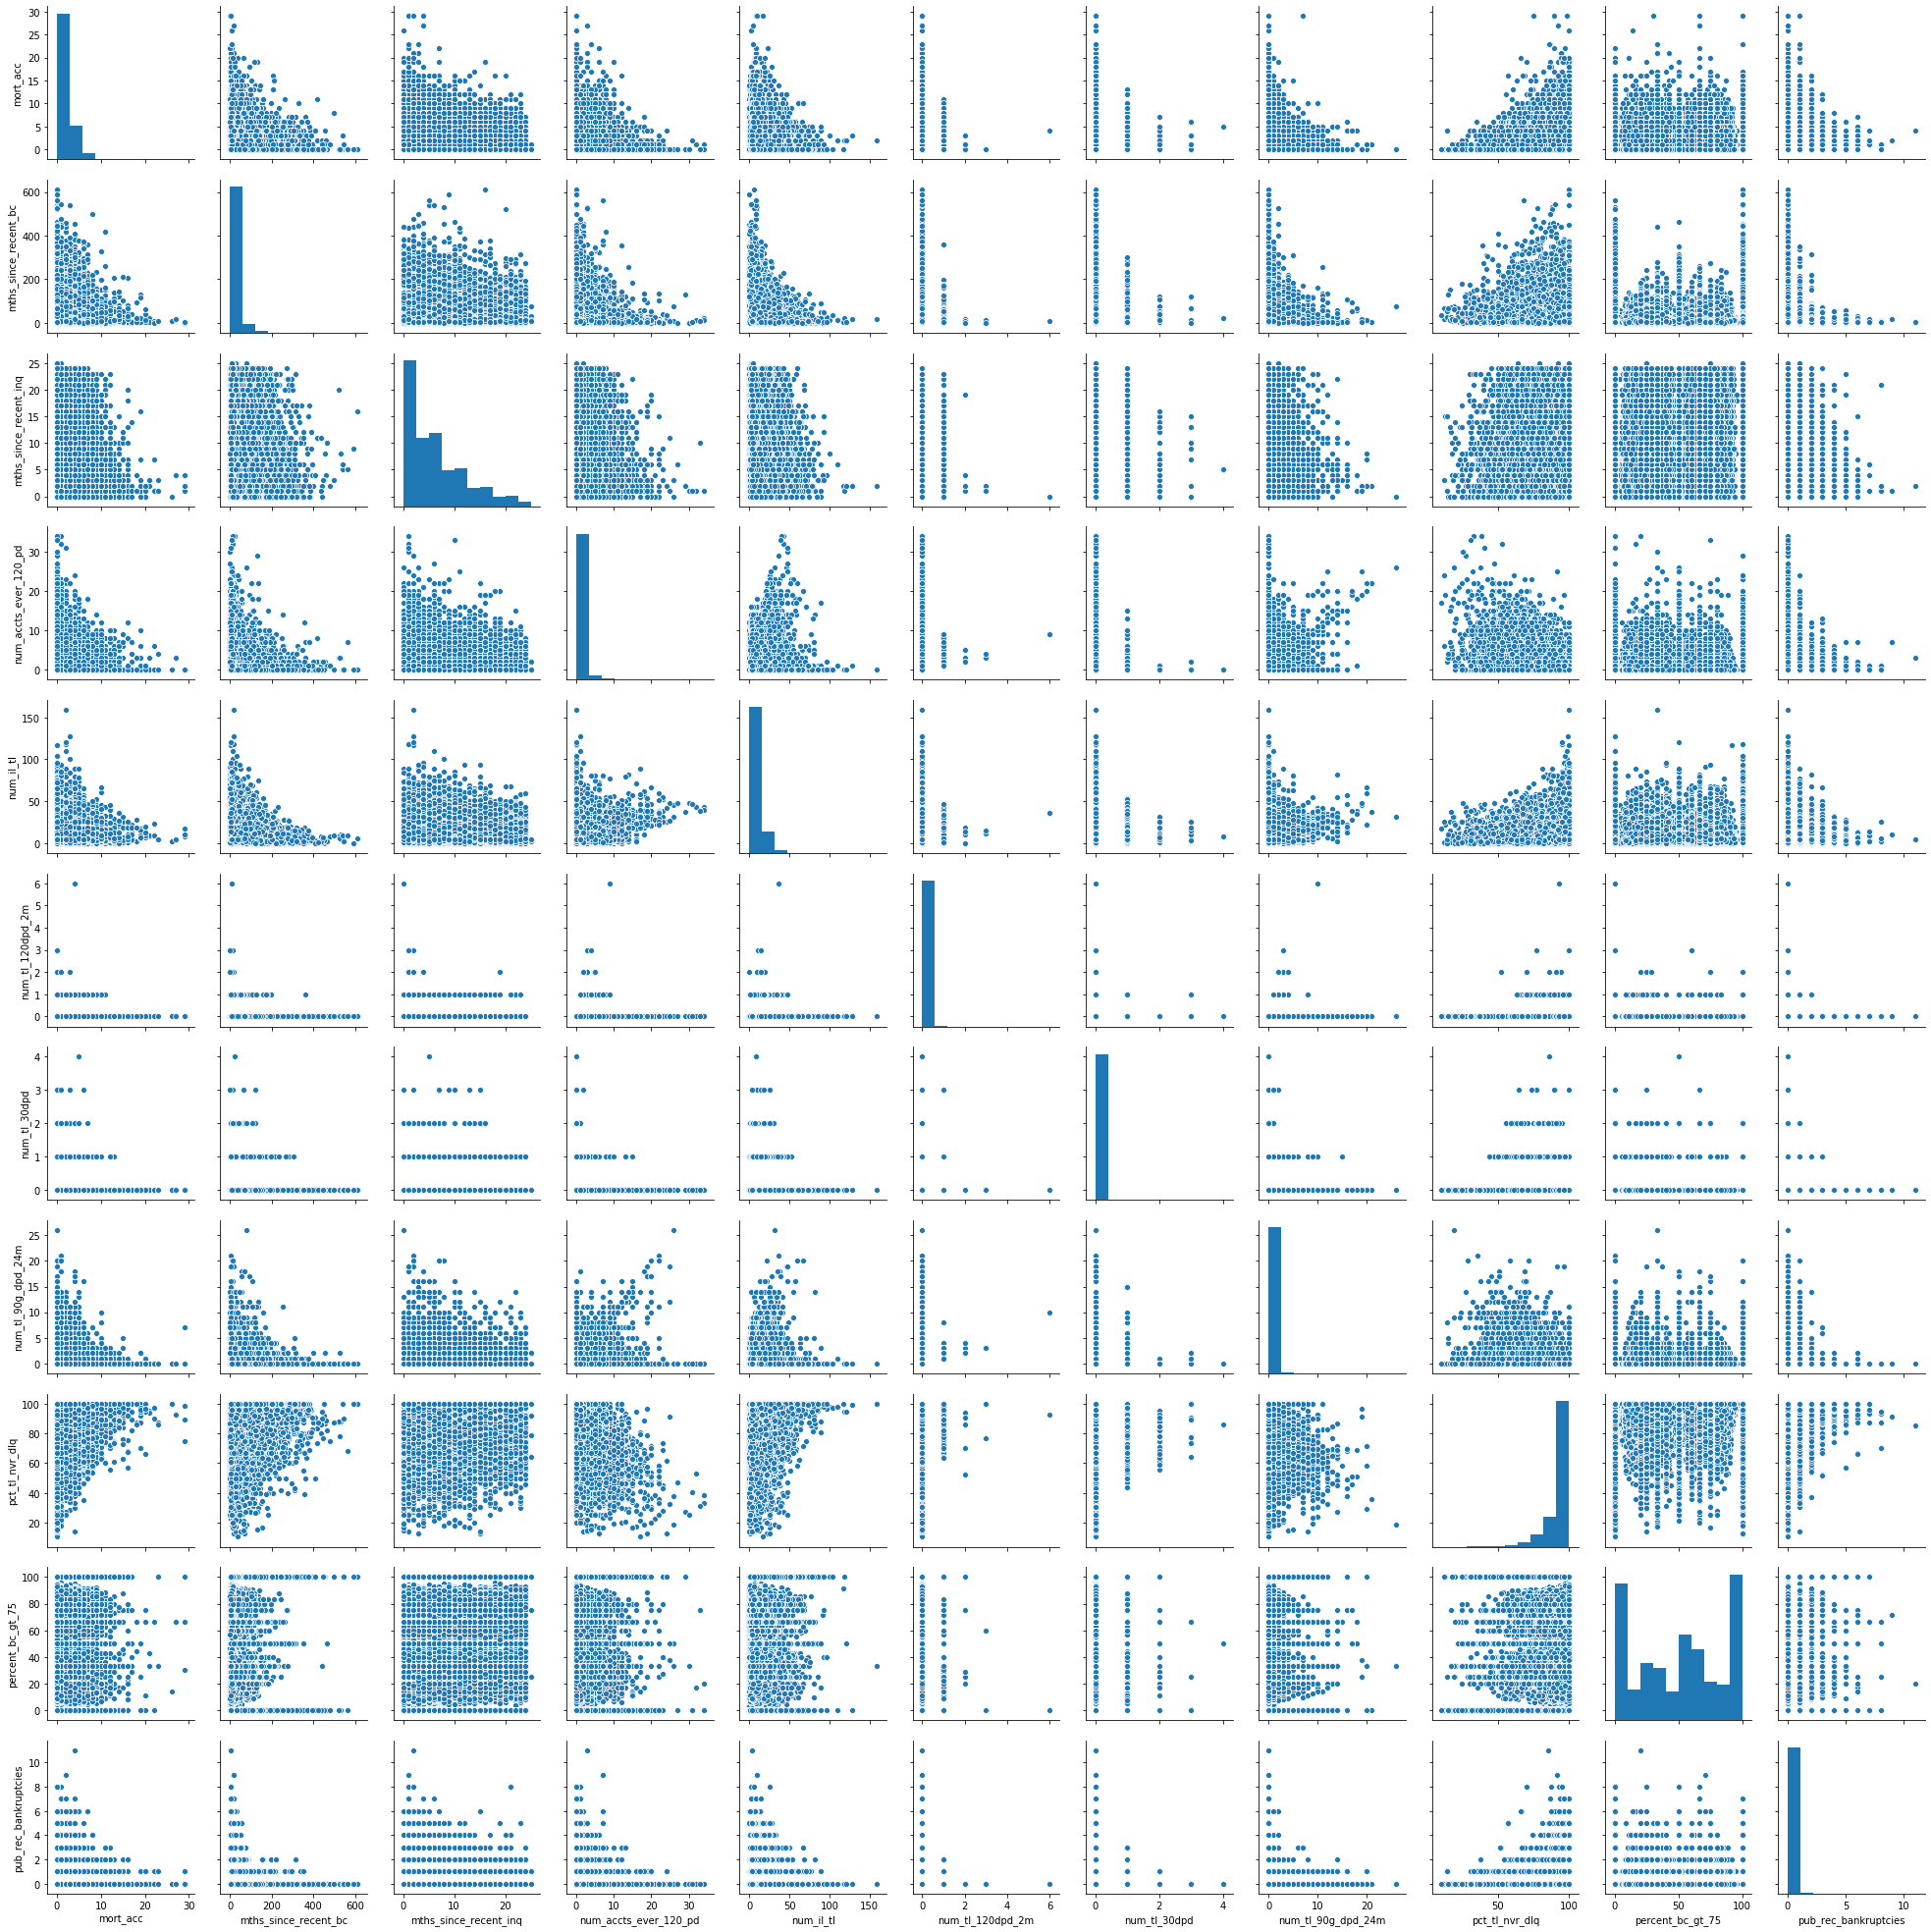

In [0]:
sns.pairplot(num_var.iloc[:,30:])

## Mort acc

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mort_acc, orient="v", ax=ax[0])
sns.distplot(lgd_data.mort_acc,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mort_acc <=9)]

Outliers greater than 9 accounts will be removed

## Months since recent bc

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.mths_since_recent_bc, orient="v", ax=ax[0])
sns.distplot(lgd_data.mths_since_recent_bc,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.mths_since_recent_bc <=175)]

Outliers greater than 175 will be removed

## Num of accounts ever 120

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.num_accts_ever_120_pd, orient="v", ax=ax[0])
sns.distplot(lgd_data.num_accts_ever_120_pd,ax=ax[1], kde=True)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.num_accts_ever_120_pd <=10)]

In [0]:
lgd_data.num_accts_ever_120_pd.value_counts()

Otliers greater than 10 will be removed

## Num il tl

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.num_il_tl, orient="v", ax=ax[0])
sns.distplot(lgd_data.num_il_tl,ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.num_il_tl <=45)]

The outliers above 45 will be removed

## Num tl 120dpd 2m

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.num_tl_120dpd_2m, orient="v", ax=ax[0])
sns.distplot(lgd_data.num_tl_120dpd_2m,ax=ax[1], kde=False)

this variable will not be significant to the model even if we make it binary, so we will remove it 

In [0]:
lgd_data.drop(["num_tl_120dpd_2m"],inplace=True,  axis=1)

## Num tl 30dpd

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.num_tl_30dpd, orient="v", ax=ax[0])
sns.distplot(lgd_data.num_tl_30dpd,ax=ax[1], kde=False)

this variable will not be significant to the model even if we make it binary, so we will remove it 

In [0]:
lgd_data.drop(["num_tl_30dpd"],inplace=True,  axis=1)

## Num tl 90g dpd 24m

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.num_tl_90g_dpd_24m, orient="v", ax=ax[0])
sns.distplot(lgd_data.num_tl_90g_dpd_24m, ax=ax[1], kde=True)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.num_tl_90g_dpd_24m <8)]

In [0]:
ntd90 = np.array(lgd_data[(lgd_data.num_tl_90g_dpd_24m>0)].num_tl_90g_dpd_24m.index)
lgd_data.loc[ntd90.transpose(), "num_tl_90g_dpd_24m"] = 1

We will remove the outliers greater than 8 and convert this variable to binary. 

## Percent of trades never delinquent

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.pct_tl_nvr_dlq, orient="v", ax=ax[0])
sns.distplot(lgd_data.pct_tl_nvr_dlq, ax=ax[1], kde=False)

In [0]:
lgd_data = lgd_data.loc[(lgd_data.pct_tl_nvr_dlq >=60)]

outliers less than 60 will be removed

##Percent bc gt 75
this one is fine

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.percent_bc_gt_75, orient="v", ax=ax[0])
sns.distplot(lgd_data.percent_bc_gt_75, ax=ax[1], kde=False)

## Pub rec bankuptcies

In [0]:
fig, ax = plt.subplots(1,2 )
sns.boxplot(lgd_data.pub_rec_bankruptcies, orient="v", ax=ax[0])
sns.distplot(lgd_data.pub_rec_bankruptcies, ax=ax[1], kde=False)

In [0]:
pubrecbank = np.array(lgd_data[(lgd_data.pub_rec_bankruptcies>0)].pub_rec_bankruptcies.index)
lgd_data.loc[pubrecbank.transpose(), "pub_rec_bankruptcies"] = 1

Last Step of Data Preprocessing, I will group the states into regions, so they will be significant.

In [0]:
reg_dic = {"CT":"1", "ME":"1", "MA":"1", "NH":"1", "RI":"1", "VT":"1",
           "NY":"2", "NJ":"2", "PA":"2",
           "WI":"3", "MI":"3", "IL":"3", "IN":"3", "OH":"3",
           "ND":"4", "MN":"4", "SD":"4", "NE":"4", "IA":"4", "KS":"4", "MO":"4",
           "MD":"5", "DE":"5", "WV":"5", "DC":"5", "VA":"5", "NC":"5", "SC":"5", "GA":"5", "FL":"5",
           "KY":"6", "TN":"6", "AL":"6", "MS":"6", 
           "AR":"7", "OK":"7", "LA":"7", "TX":"7",
           "MT":"8", "ID":"8", "WY":"8", "NV":"8", "UT":"8", "CO":"8", "AZ":"8", "NM":"8",
           "WA":"9", "OR":"9", "CA":"9", "AK":"9", "HI":"9"
           }

In [0]:
lgd_data["addr_region"] = lgd_data.addr_state.map(reg_dic)
lgd_data.drop(["addr_state"], axis=1, inplace=True)

Making homeownership significant

We will add any other and none to the rent category

In [0]:
rent = np.array(lgd_data[(lgd_data.home_ownership == "ANY") | (lgd_data.home_ownership == "OTHER") | (lgd_data.home_ownership == "NONE")].home_ownership.index)
lgd_data.loc[rent.transpose(), "home_ownership"] = "RENT"

Making the purpose columns significant

Medical, car, vacation, moving, house, wedding, education will be put in a category call living_leasure_expenses 

major_purchase, small_business and renewable_energy will be include in others

In [0]:
purpose1 = np.array(lgd_data[(lgd_data.purpose == "medical") | (lgd_data.purpose == "car") | (lgd_data.purpose == "vacation") |
                        (lgd_data.purpose == "moving") | (lgd_data.purpose == "house") | (lgd_data.purpose == "wedding") |
                        (lgd_data.purpose == "educational")].purpose.index)
lgd_data.loc[purpose1.transpose(), "purpose"] = "liv_leisure_exp" 
purpose2 = np.array(lgd_data[(lgd_data.purpose == "small_business") | (lgd_data.purpose == "renewable_energy") | (lgd_data.purpose == "major_purchase")].purpose.index)
lgd_data.loc[purpose2.transpose(), "purpose"] = "other"

In [0]:
len(lgd_data.columns)

46

In [0]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 4000)
display(lgd_data.columns)

Index(['term', 'emp_length', 'home_ownership', 'annual_inc', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'mths_since_rcnt_il', 'il_util', 'open_rv_12m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'bc_open_to_buy', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_il_tl', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'debt_settlement_flag', 'lgd'], dtype='object')

In [0]:
lgd_data.to_csv("lgd_data.csv", index=False)